# Community detection using NETWORKX 


In [26]:
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nxcom
from matplotlib.pyplot import figure, text
import itertools
import numpy as np

df = pd.read_csv("final_data.csv",sep=';',error_bad_lines=False,dtype = 'str')

# Network preparation


In [18]:
G = nx.Graph()

# Tags Edges
for i, row in df.iterrows():
        if i<10000:
                tagArray = row['tags'].split(',')
                tagsCount = 0
                for tag in tagArray:
                        tagsCount += 1
                        userID = row['id'].strip()
                        G.add_edge(userID, tag.strip(), color='r', weight=1, hastag=row['tags'])

# Friends Edges
for i, row in df.iterrows():
     if i<0:
        friendsArray = row['friends'].split(',')
        friendsCount = 0
        for friend in friendsArray:
             friendsCount += 1
             userID = row['id']
             G.add_edge(userID, friend, color='r', weight=1, hastag=row['tags'])

colors = nx.get_edge_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()
hastags = nx.get_edge_attributes(G,'hastag').values()

# Community detection

In [6]:
def set_node_community(G, communities):
        #Add community attributes
        for c, v_c in enumerate(communities):
            #print(v_c)
            for v in v_c:
                # Set community for each node
                G.nodes[v]['community'] = c + 1

def get_color(i, r_off=1, g_off=1, b_off=1):
        #Assign a color to a vertex.
        r0, g0, b0 = 0, 0, 0
        n = 16
        low, high = 0.1, 0.9
        span = high - low
        r = low + span * (((i + r_off) * 3) % n) / (n - 1)
        g = low + span * (((i + g_off) * 5) % n) / (n - 1)
        b = low + span * (((i + b_off) * 7) % n) / (n - 1)
        return (r, g, b)  
    
def set_edge_community(G):
        # Set internal/external edges attributes
        # f - From / t - To Index
        for f, t, in G.edges:
            if G.nodes[f]['community'] == G.nodes[t]['community']:
                G.edges[f, t]['community'] = G.nodes[f]['community']
            else:
                G.edges[f, t]['community'] = 0

In [7]:
communities = sorted(nxcom.greedy_modularity_communities(G), key=len)
#communities = next(nxcom.girvan_newman(G))
#communities = nxcom.label_propagation_communities(G)

set_node_community(G, communities)
set_edge_community(G)

In [24]:
labels = {}
counts = {}
# Set center nodes attributes
for c, community in enumerate(communities):
    subGraph = G.subgraph(community)
    if len(subGraph.nodes) > 10:
        #print("{}: {}".format(nx.center(subGraph)[0], len(subGraph.nodes)))
        labels[nx.center(subGraph)[0]] = nx.center(subGraph)[0]
        
        if len(subGraph.nodes) < 100 & len(subGraph.nodes) >= 40:
            counts[nx.center(subGraph)[0]] = len(subGraph.nodes)
        elif len(subGraph.nodes) < 40:
            counts[nx.center(subGraph)[0]] = 40
        else:
            counts[nx.center(subGraph)[0]] = 100


# Nodes preparation

In [15]:
node_color = [get_color(G.nodes[i]['community']) for i in G.nodes]
external = [(f, t) for f, t in G.edges if G.edges[f, t]['community'] == 0]
internal = [(f, t) for f, t in G.edges if G.edges[f, t]['community'] > 0]
internal_color = [get_color(G.edges[i]['community']) for i in internal]

In [16]:
pos = nx.spring_layout(G,k=0.1, iterations=150)
#pos = nx.kamada_kawai_layout(G)

<Figure size 1800x1200 with 0 Axes>

# Plot the network

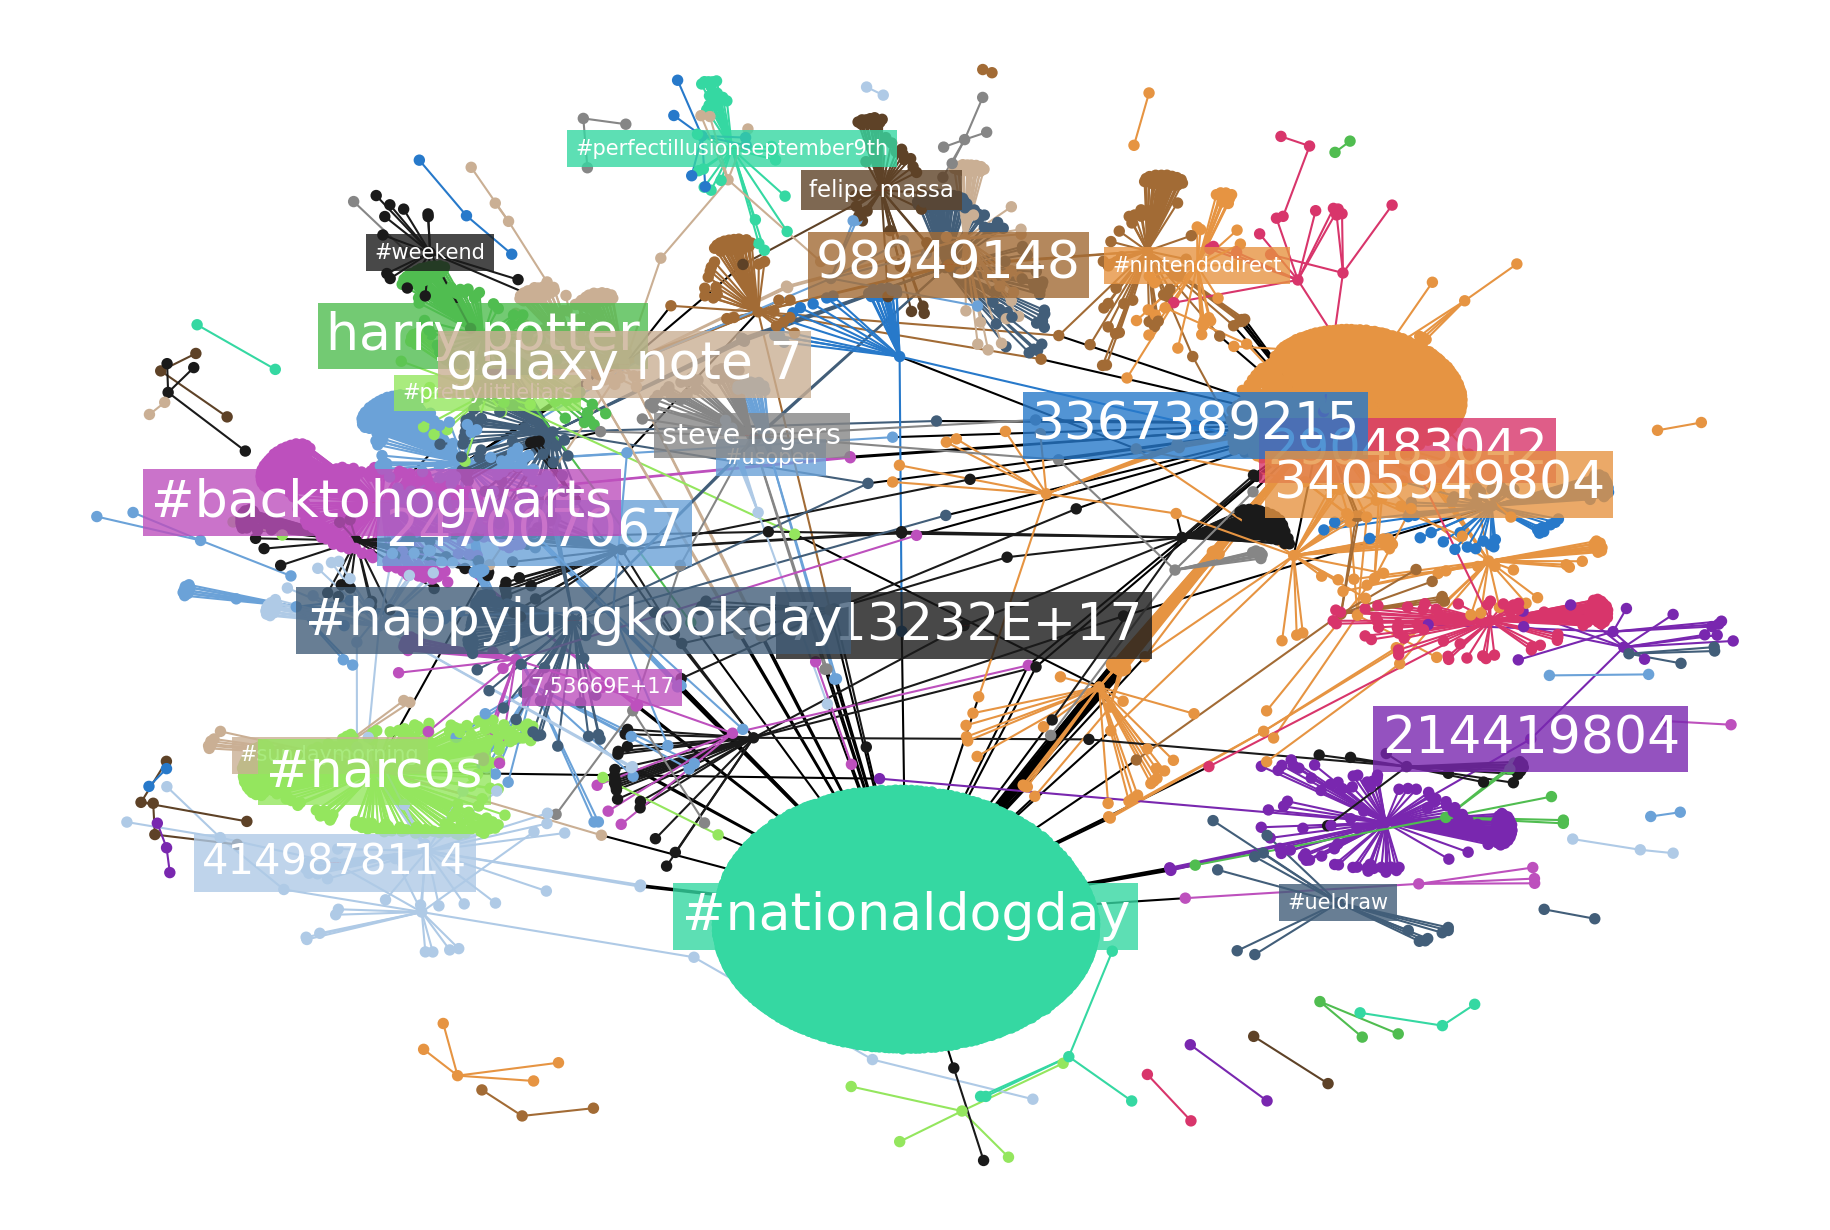

In [537]:
plt.figure(figsize=(12,8), dpi= 150, facecolor='w', edgecolor='k')

# External egdes & nodes
nx.draw(
        G, pos=pos, node_size=0,
        edgelist=external, edge_color="black", with_labels=False)

# Internal egdes & nodes
nx.draw(
        G, pos=pos, node_color=node_color, node_size = 20,
        edgelist=internal, edge_color=internal_color, with_labels=False)

# Labels
labs = nx.draw_networkx_labels(G,pos,labels,font_size=0,font_color='r')

for node in labs:
    (x,y) = pos[node]
    text(x, y, node, fontsize=counts[node]/4, ha='center', va='center',bbox=dict(facecolor=get_color(G.nodes[node]['community']), alpha=0.8,edgecolor=get_color(G.nodes[node]['community']), linewidth=0.0),color="white")